<a href="https://colab.research.google.com/github/gunjanvjangra/Credit-Card-Approval-Prediction/blob/main/Credict_Card_Aprroval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
rikdifos_credit_card_approval_prediction_path = kagglehub.dataset_download('rikdifos/credit-card-approval-prediction')

print('Data source import complete.')


Using Colab cache for faster access to the 'credit-card-approval-prediction' dataset.
Data source import complete.


In [ ]:
import kagglehub
path = kagglehub.dataset_download("rikdifos/credit-card-approval-prediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'credit-card-approval-prediction' dataset.
Path to dataset files: /kaggle/input/credit-card-approval-prediction


In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
dataset_dir = "/kaggle/input/credit-card-approval-prediction"
app_path = os.path.join(dataset_dir, "application_record.csv")
cred_path = os.path.join(dataset_dir, "credit_record.csv")


====================== Logistic Regression ======================
Accuracy : 0.6242457487657707
Precision: 0.02016868353502017
Recall   : 0.44715447154471544
F1 Score : 0.03859649122807018
ROC-AUC  : 0.5443145566899943

Confusion Matrix:
[[4497 2672]
 [  68   55]]

====================== Random Forest ======================
Accuracy : 0.9622874382885354
Precision: 0.1910569105691057
Recall   : 0.3821138211382114
F1 Score : 0.25474254742547425
ROC-AUC  : 0.8036776455084959

Confusion Matrix:
[[6970  199]
 [  76   47]]

====================== Support Vector Machine (SVM) ======================
Accuracy : 0.7825013713658804
Precision: 0.03673210892970234
Recall   : 0.4715447154471545
F1 Score : 0.0681551116333725
ROC-AUC  : 0.6518087701451711

Confusion Matrix:
[[5648 1521]
 [  65   58]]


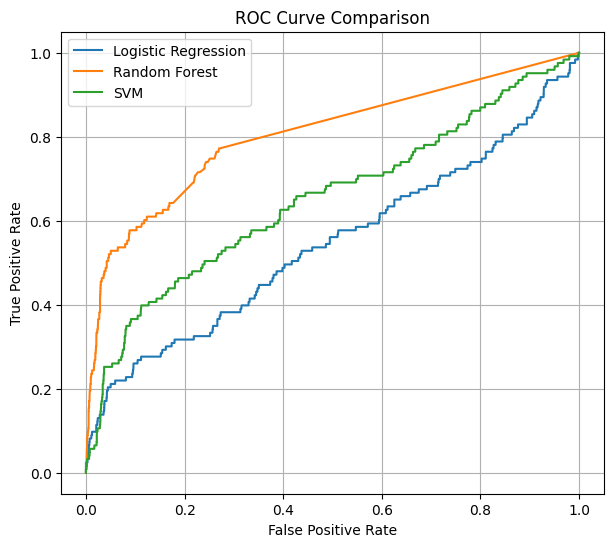

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

app = pd.read_csv(app_path)
cred = pd.read_csv(cred_path)

bad_status = ["2", "3", "4", "5"]
cred["Default"] = cred["STATUS"].apply(lambda x: 1 if x in bad_status else 0)
cred_default = cred.groupby("ID")["Default"].max().reset_index()

merged = app.merge(cred_default, on="ID", how="inner")

merged = merged.drop(columns=["OCCUPATION_TYPE"])

X = merged.drop(columns=["Default", "ID"])
y = merged["Default"]

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print(f"\n====================== {name} ======================")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))

    if y_proba is not None:
        print("ROC-AUC  :", roc_auc_score(y_test, y_proba))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


logistic_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logistic_model.fit(X_train, y_train)
evaluate_model("Logistic Regression", logistic_model, X_test, y_test)


rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_test, y_test)


svm_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced"
    ))
])

svm_model.fit(X_train, y_train)
evaluate_model("Support Vector Machine (SVM)", svm_model, X_test, y_test)


plt.figure(figsize=(7,6))

y_lp = logistic_model.predict_proba(X_test)[:,1]
fpr_l, tpr_l, _ = roc_curve(y_test, y_lp)
plt.plot(fpr_l, tpr_l, label="Logistic Regression")

y_rp = rf_model.predict_proba(X_test)[:,1]
fpr_r, tpr_r, _ = roc_curve(y_test, y_rp)
plt.plot(fpr_r, tpr_r, label="Random Forest")

y_sp = svm_model.predict_proba(X_test)[:,1]
fpr_s, tpr_s, _ = roc_curve(y_test, y_sp)
plt.plot(fpr_s, tpr_s, label="SVM")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


In [ ]:

import pandas as pd

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

key_cat_cols = [
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'FLAG_OWN_REALTY'
]

def create_default_rate_table(df, col):
    """Calculates default rate (mean of 'Default') for each category."""
    rate_df = df.groupby(col)['Default'].agg(
        ['count', 'sum', 'mean']
    ).reset_index()

    rate_df.columns = [col, 'Total Applicants', 'Total Defaulters', 'Default Rate']

    rate_df['Default Rate (%)'] = (rate_df['Default Rate'] * 100).round(3)

    return rate_df.sort_values(by='Default Rate', ascending=False)
for col in key_cat_cols:
    default_rate_table = create_default_rate_table(merged, col)

    print(f"\n                  Default Rate by {col.replace('NAME_', '').replace('FLAG_', '')}               ")
    print(default_rate_table.drop(columns=['Default Rate']))


                  Default Rate by INCOME_TYPE               
       NAME_INCOME_TYPE  Total Applicants  Total Defaulters  Default Rate (%)
1             Pensioner              6152               130             2.113
0  Commercial associate              8490               143             1.684
4               Working             18819               306             1.626
2         State servant              2985                37             1.240
3               Student                11                 0             0.000

                  Default Rate by EDUCATION_TYPE               
             NAME_EDUCATION_TYPE  Total Applicants  Total Defaulters  Default Rate (%)
3                Lower secondary               374                10             2.674
2              Incomplete higher              1410                33             2.340
1               Higher education              9864               171             1.734
4  Secondary / secondary special             24777       

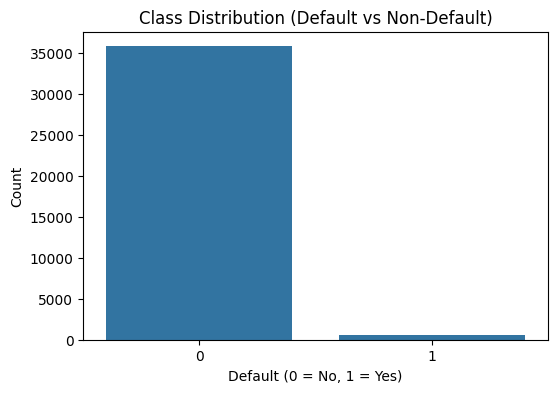

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Class Distribution (Default vs Non-Default)")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


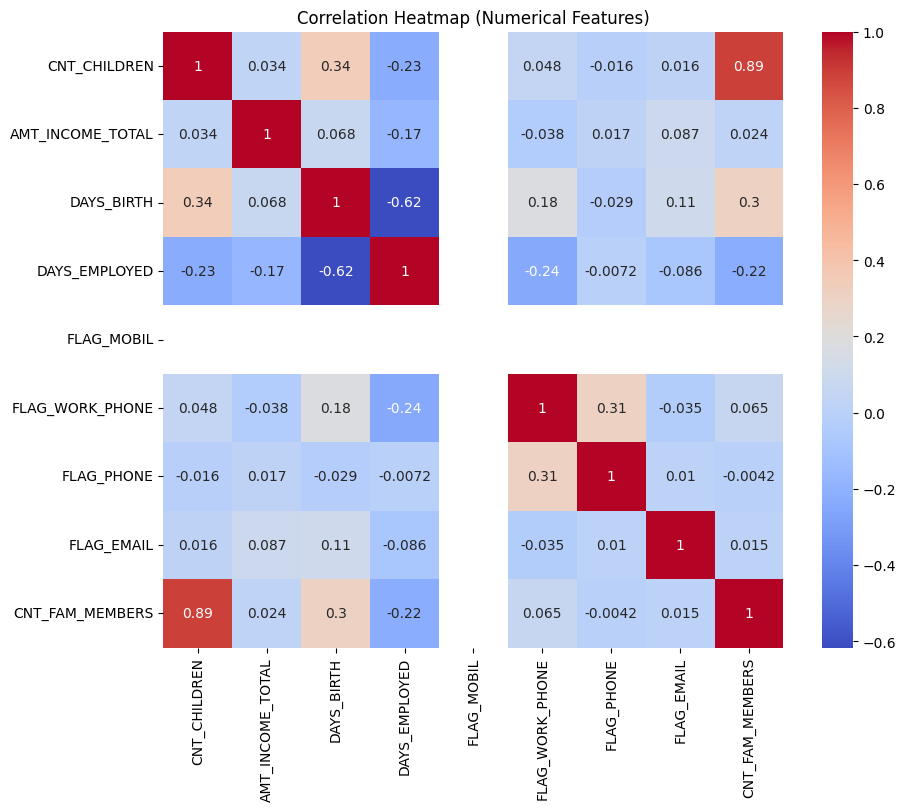

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(merged[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


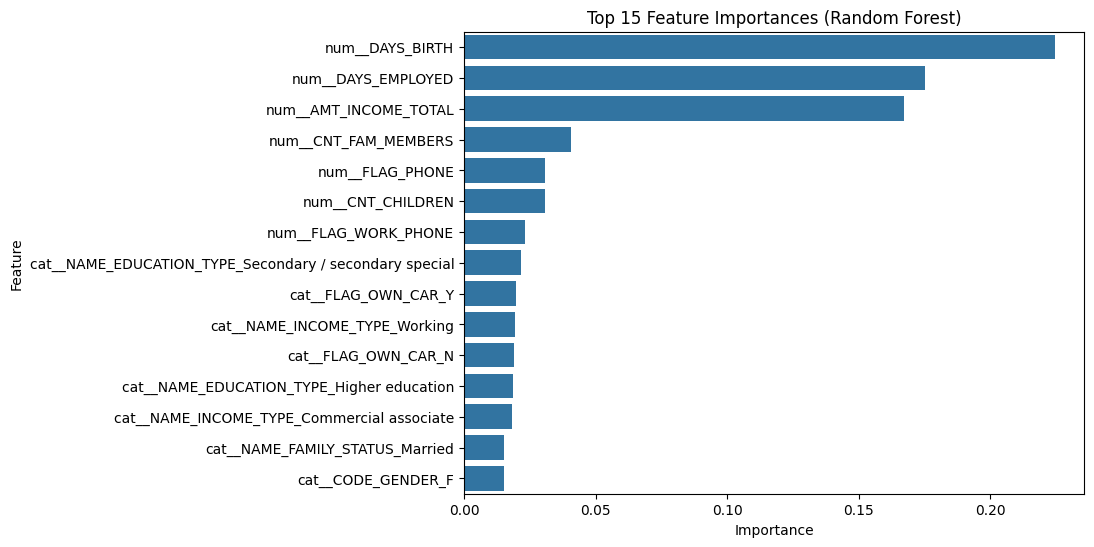

In [ ]:
importances = rf_model.named_steps["classifier"].feature_importances_

feature_names = rf_model.named_steps["preprocessor"].get_feature_names_out()

imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df, x="Importance", y="Feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


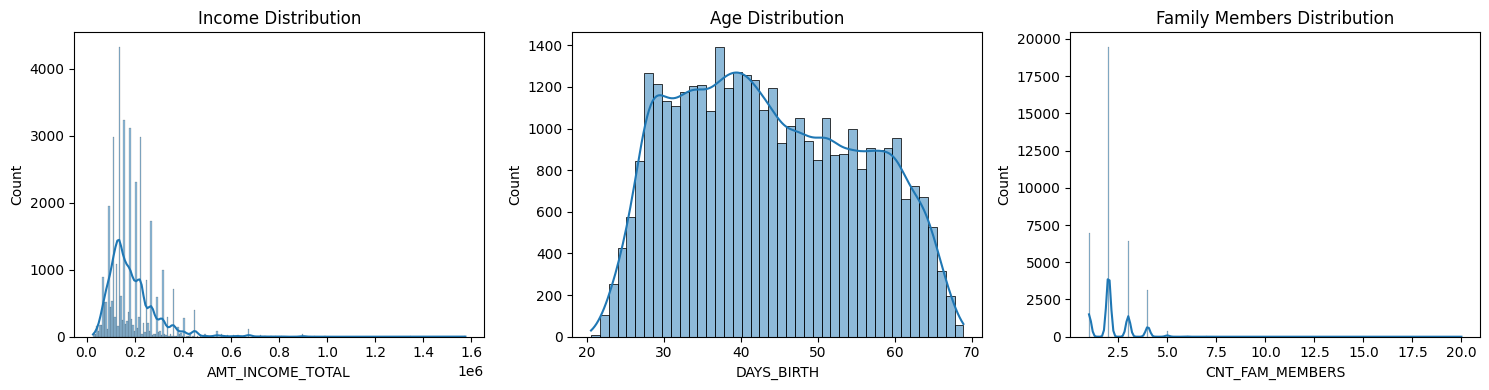

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(merged["AMT_INCOME_TOTAL"], kde=True, ax=ax[0])
ax[0].set_title("Income Distribution")

sns.histplot(-merged["DAYS_BIRTH"]/365, kde=True, ax=ax[1])
ax[1].set_title("Age Distribution")

sns.histplot(merged["CNT_FAM_MEMBERS"], kde=True, ax=ax[2])
ax[2].set_title("Family Members Distribution")

plt.tight_layout()
plt.show()


In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def get_metrics(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    return metrics
models = [
    ("Logistic Regression", logistic_model),
    ("Random Forest", rf_model),
    ("Support Vector Machine (SVM)", svm_model)
]
results = []
for name, model in models:
    results.append(get_metrics(name, model, X_test, y_test))
performance_df = pd.DataFrame(results).set_index("Model")

print("\n====================== Model Performance Comparison ======================")
print(performance_df)


====================== Model Performance Comparison ======================
                              Accuracy  Precision    Recall  F1 Score   ROC-AUC
Model                                                                          
Logistic Regression           0.624246   0.020169  0.447154  0.038596  0.544315
Random Forest                 0.962287   0.191057  0.382114  0.254743  0.803678
Support Vector Machine (SVM)  0.782501   0.036732  0.471545  0.068155  0.651809


In [ ]:
# Calculate counts and percentages
class_counts = merged["Default"].value_counts()
class_percentages = merged["Default"].value_counts(normalize=True) * 100

# Create the DataFrame
class_distribution_df = pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percentages
})

# Rename index AFTER DataFrame creation
class_distribution_df.index = ["Non-Default (0)", "Default (1)"]

print(" Target Class Distribution ")
print(class_distribution_df)


 Target Class Distribution 
                 Count  Percentage
Non-Default (0)  35841   98.310338
Default (1)        616    1.689662


In [ ]:

importances = rf_model.named_steps["classifier"].feature_importances_
feature_names = rf_model.named_steps["preprocessor"].get_feature_names_out()

# Create DataFrame
imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance Score": importances
})
top_imp_df = imp_df.sort_values(by="Importance Score", ascending=False).head(15)
top_imp_df['Importance Score'] = top_imp_df['Importance Score'].round(6)

print("           Top 15 Feature Importances (Random Forest)")
print(top_imp_df.reset_index(drop=True))

           Top 15 Feature Importances (Random Forest)
                                              Feature  Importance Score
0                                     num__DAYS_BIRTH          0.224507
1                                  num__DAYS_EMPLOYED          0.175176
2                               num__AMT_INCOME_TOTAL          0.167380
3                                num__CNT_FAM_MEMBERS          0.040691
4                                     num__FLAG_PHONE          0.030942
5                                   num__CNT_CHILDREN          0.030783
6                                num__FLAG_WORK_PHONE          0.023313
7   cat__NAME_EDUCATION_TYPE_Secondary / secondary...          0.021539
8                                 cat__FLAG_OWN_CAR_Y          0.019812
9                       cat__NAME_INCOME_TYPE_Working          0.019492
10                                cat__FLAG_OWN_CAR_N          0.019165
11          cat__NAME_EDUCATION_TYPE_Higher education          0.018619
12        